In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os
from math import inf

In [2]:
data_path = fr'C:\ML\DataBases\img'

os.listdir(data_path)

['benign', 'malignant']

In [3]:
batch_size = 32

img_height, img_width = 224, 224

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=43,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 3297 files belonging to 2 classes.
Using 2638 files for training.


In [5]:
test_ds = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=43,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.


## Функция вычисления погрешности измерений

In [6]:

def eps(type_eps: str, x1: float | int, x2: float | int) -> float:
    """Погрешность"""
    if type_eps == 'rel':
        try:
            return (x2 - x1) / x1  # относительная
        except ZeroDivisionError:
            return inf
    if type_eps == 'abs': return x2 - x1  # абсолютная


## Функция анализа обучения модели

In [7]:
def training_analyze(epochs: int, acc, loss=0, val_acc=None, val_loss=None,
                     figsize=(10, 10), fontsize=12):
    """Анализ результата тренировки"""
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc: plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xticks(epochs_range)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=fontsize)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss: plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xticks(epochs_range)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=fontsize)

    plt.show()

# Функция нахождения количества эпох

In [8]:
def count_epochs(train_ds, max_epochs, min_batch_size=16, k_batch_size=2, min_difference: tuple=(0.05, 0.05), 
                 img_height=100, img_width=100, number_layers=1, num_classes=2):
    """функция подсчета нужного количества эпох для обучения модели
    max_epochs - максимальное количество эпох, которое будет рассмотрено (не меньше 2)
    min_batch_size - batch_size для первого слоя
    k_batch_size - коэффициент изменения batch_size с каждым слоем
    min_difference - картеж из минимальных значений разницы точности модели и потерь при обучении (accuracy, loss)
    train_ds - датасет, на котором обучается модель
    number_layers - количество слоев в модели"""

    loss_for_plot = []
    acc_for_plot = []

    model = Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))
    ])
    for i in range(number_layers-1):
        model.add(layers.Conv2D(min_batch_size, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        if min_batch_size != 128: min_batch_size *= k_batch_size

    model.add(layers.Flatten())
    model.add(layers.Dense(min_batch_size, activation='relu'))
    model.add(layers.Dense(num_classes))

    model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    print('ЭПОХА 1')
    history = model.fit(
        train_ds,
        epochs=1
    )
    
    prev_loss = history.history['loss'][-1]
    prev_acc = history.history['accuracy'][-1]

    loss_for_plot.append(prev_loss)
    acc_for_plot.append(prev_acc)

    for i in range(2, max_epochs+1):
        print(f'ЭПОХА {i}')
        history = model.fit(
            train_ds,
            epochs=1
        )

        loss_for_plot.append(history.history['loss'][-1])
        acc_for_plot.append(history.history['accuracy'][-1])

        if  (-0.05 <= eps('rel', prev_acc, history.history['accuracy'][-1]) <= min_difference[0] or history.history['accuracy'][-1] >= 0.90) \
        and (-0.05 <= eps('rel', history.history['loss'][-1], prev_loss) <= min_difference[1] or history.history['loss'][-1] <= 0.2):
            return model, acc_for_plot, loss_for_plot, i
        prev_loss = history.history['loss'][-1]
        prev_acc = history.history['accuracy'][-1]
    return model, acc_for_plot, loss_for_plot, i

# Функция подбора оптимальных параметров

In [9]:
def find_optimal_params(train_ds, min_batch_size=16, k_batch_size=2, min_difference=(0.05, 0.05), 
                        img_height=100, img_width=100, num_classes=2, max_num_layers=5):
    print('1 СЛОЙ')
    clf, acc, loss, num_epochs = count_epochs(
        train_ds=train_ds,
        max_epochs=25,
        min_batch_size=min_batch_size,
        k_batch_size=k_batch_size,
        min_difference=min_difference,
        img_height=img_height,
        img_width=img_width,
        number_layers=1,
        num_classes=num_classes
    )

    prev_acc = acc[-1]
    prev_loss = loss[-1]

    for i in range(2, max_num_layers+1):
        print(f'{i} СЛОЙ')
        clf, acc, loss, num_epochs = count_epochs(
            train_ds=train_ds,
            max_epochs=25,
            min_batch_size=min_batch_size,
            k_batch_size=k_batch_size,
            min_difference=min_difference,
            img_height=img_height,
            img_width=img_width,
            number_layers=i,
            num_classes=num_classes
        )

        if ((-0.05 <= eps('rel', prev_acc, acc[-1]) <= min_difference[0] and acc[-1] >= 0.65) and \
            (-0.05 <= eps('rel', loss[-1], prev_loss) <= min_difference[1] and loss[-1] <= 0.5)) or \
            (acc[-1] > 0.85 and loss[-1] < 0.35):
            print('найден лучший вариант модели')
            return clf, acc, loss, num_epochs, i
        prev_acc = acc[-1]
        prev_loss = loss[-1]
    return clf, None, None, None

In [10]:
model, acc, loss, num_epochs, num_layers = find_optimal_params(
    train_ds=train_ds,
    min_difference=(0.05, 0.05),
    img_height=224,
    img_width=224,
    max_num_layers=8
)

1 СЛОЙ
ЭПОХА 1
83/83 [==============================] - 3s 35ms/step - loss: 2.5054 - accuracy: 0.5470
ЭПОХА 2
83/83 [==============================] - 3s 34ms/step - loss: 0.6907 - accuracy: 0.5462
ЭПОХА 3
83/83 [==============================] - 3s 34ms/step - loss: 0.6897 - accuracy: 0.5462
2 СЛОЙ
ЭПОХА 1
83/83 [==============================] - 19s 226ms/step - loss: 0.7613 - accuracy: 0.7153
ЭПОХА 2
83/83 [==============================] - 19s 229ms/step - loss: 0.4640 - accuracy: 0.7745
ЭПОХА 3
83/83 [==============================] - 19s 229ms/step - loss: 0.3639 - accuracy: 0.8245
ЭПОХА 4
83/83 [==============================] - 19s 231ms/step - loss: 0.3317 - accuracy: 0.8332
ЭПОХА 5
83/83 [==============================] - 19s 232ms/step - loss: 0.2973 - accuracy: 0.8624
ЭПОХА 6
83/83 [==============================] - 19s 231ms/step - loss: 0.2684 - accuracy: 0.8810
ЭПОХА 7
83/83 [==============================] - 19s 230ms/step - loss: 0.2333 - accuracy: 0.9033
ЭПОХА 8
83/8

## Анализ обученной модели

In [23]:
res = model.evaluate(test_ds, batch_size=32)
print(f'loss: {res[0]}')
print(f'acc: {res[1]}')

21/21 [==============================] - 1s 51ms/step - loss: 0.4670 - accuracy: 0.7906
loss: 0.46697765588760376
acc: 0.7905917763710022


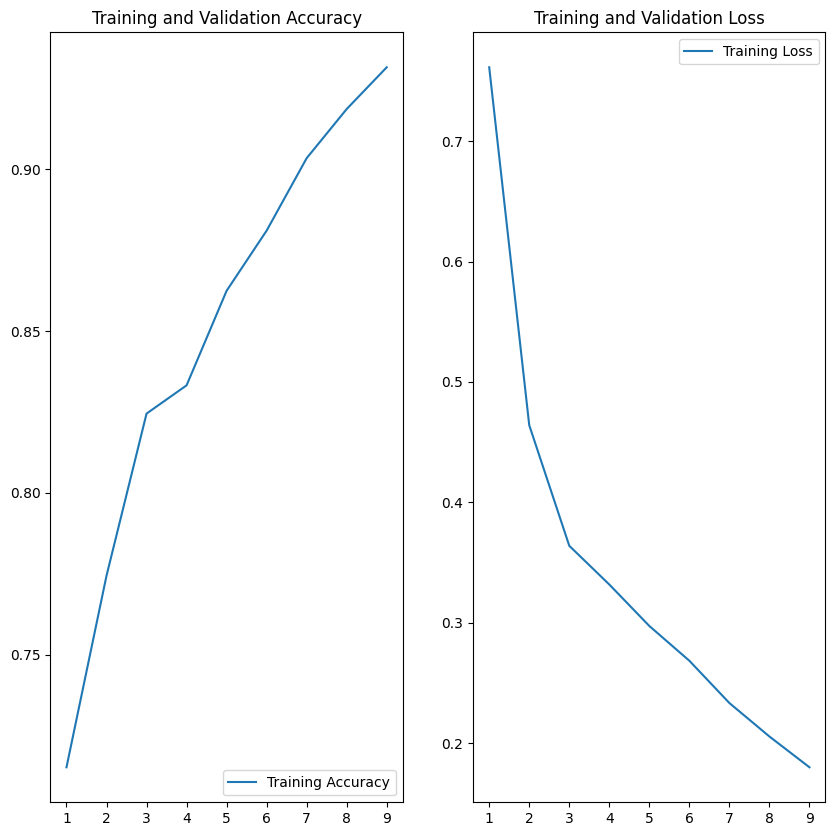

In [26]:
training_analyze(num_epochs, acc, loss)

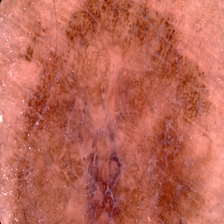

In [27]:
img = tf.keras.utils.load_img(
    '234.jpg', 
    target_size=(img_height, img_width))
img

In [28]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['benign', 'malignant']

print(f"Это изображение на {round(np.max(score) * 100, 2)} % похоже на {class_names[np.argmax(score)]}")

1/1 [==============================] - 0s 16ms/step
Это изображение на 100.0 % похоже на malignant
